# Analysis of data after cleaning/normalization

## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import math
import seaborn as sns

In [2]:
METADATA_FILE = 'gwas_trait_metadata.csv'
UNKNOWN_GENE = 'UNKNOWN'
CHILD_TRAIT_DELIMITER = ';'
TISSUE_DELIM = "&"

metadata_df = pd.read_csv(METADATA_FILE)
all_traits = metadata_df['Trait'].tolist()
print(all_traits)

['attention deficit hyperactivity disorder', 'alzheimer disease', 'anxiety disorder', 'autism spectrum disorder', 'bipolar disorder', 'drug dependence', 'eating disorder', 'personality disorder', 'schizophrenia', 'tourette syndrome', 'unipolar depression']


In [3]:
def trait_to_cleaned_filename(trait):
    return trait.replace(" ", "_") + ".csv"


trait_to_df = {
    trait: pd.read_csv(trait_to_cleaned_filename(trait)) for trait in all_traits
}
# Shorten to ADHD for brevity in plots:
trait_to_df['ADHD'] = trait_to_df['attention deficit hyperactivity disorder']
trait_to_df.pop('attention deficit hyperactivity disorder')
all_traits.remove('attention deficit hyperactivity disorder')
all_traits.append('ADHD')

In [4]:
trait_to_df['schizophrenia'].head()

,variant_and_allele,p_value,trait,gene,location,af,tissues
0,rs3130820-<b>?</b>,2.000000e-44,schizophrenia,OR2U1P,6:29238906,-1.0,NaN
1,rs3130820-<b>?</b>,2.000000e-44,schizophrenia,OR2G1P,6:29238906,-1.0,NaN
2,rs115329265-<b>A</b>,5.000000e-36,schizophrenia,NOP56P1,6:28744470,-1.0,Brain_Caudate_basal_ganglia&Artery_Tibial&Brai...
3,rs115329265-<b>A</b>,5.000000e-36,schizophrenia,RPSAP2,6:28744470,-1.0,Brain_Caudate_basal_ganglia&Artery_Tibial&Brai...
4,rs9257566-<b>?</b>,7.000000e-30,schizophrenia,OR2J2,6:29176755,-1.0,Artery_Coronary&Brain_Caudate_basal_ganglia&Ar...


## Comparing summary stats of data for all traits

In [5]:
trait_summaries = []
for trait in all_traits:
  trait_df = trait_to_df[trait]
  if trait == 'attention deficit hyperactivity disorder':
    # Shorten for plots
    trait = 'ADHD'
  trait_df['parent_trait'] = trait
  
  num_unknown_genes = len(trait_df.loc[trait_df['gene'] == UNKNOWN_GENE])
  trait_summary = {
      'parent_trait': trait,
      'num_variants': len(trait_df),
      'num_unique_genes': len(trait_df['gene'].unique()),
      'num_unknown_genes': num_unknown_genes,
      'min_pval': trait_df['p_value'].min(),
      'max_pval': trait_df['p_value'].max(),
  }
  trait_summaries.append(trait_summary)

summary_df = pd.DataFrame(trait_summaries)
summary_df

,parent_trait,num_variants,num_unique_genes,num_unknown_genes,min_pval,max_pval
0,alzheimer disease,764,495,40,2.000000e-303,0.000009
1,anxiety disorder,250,222,16,7.000000e-22,0.000009
2,autism spectrum disorder,179,145,16,4.000000e-13,0.000009
3,bipolar disorder,854,509,106,1.000000e-21,0.000009
4,drug dependence,345,259,28,1.000000e-70,0.000009
5,eating disorder,119,105,10,7.000000e-15,0.000009
6,personality disorder,33,28,6,2.000000e-07,0.000009
7,schizophrenia,2205,1122,251,2.000000e-44,0.000009
8,tourette syndrome,39,38,2,3.000000e-08,0.000009
9,unipolar depression,1237,810,95,4.000000e-52,0.000009


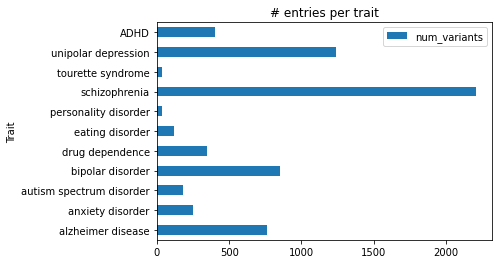

In [6]:
summary_df.plot(kind='barh', title='# entries per trait',
                x='parent_trait', y='num_variants',
                xlabel='Trait')

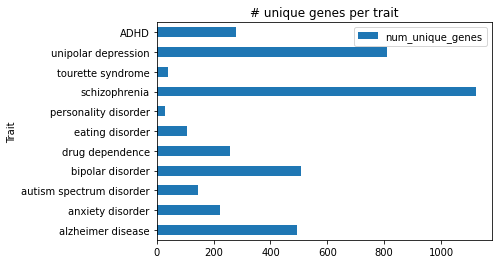

In [7]:
summary_df.plot(kind='barh', title='# unique genes per trait',
                x='parent_trait', y='num_unique_genes',
                xlabel='Trait')

In [8]:
all_df = pd.concat(df for df in trait_to_df.values())
all_df.head()

,variant_and_allele,p_value,trait,gene,location,af,tissues,parent_trait
0,rs429358-<b>?</b>,2.000000e-303,alzheimer disease,APOE,19:44908684,-1.000000,NaN,alzheimer disease
1,rs2075650-<b>G</b>,1.000000e-295,alzheimer disease,TOMM40,19:44892362,0.128939,NaN,alzheimer disease
2,rs429358-<b>C</b>,5.000000e-286,alzheimer disease,APOE,19:44908684,0.074418,NaN,alzheimer disease
3,rs41289512-<b>G</b>,3.000000e-194,alzheimer disease,NECTIN2,19:44848259,0.028322,NaN,alzheimer disease
4,rs2075650-<b>?</b>,2.000000e-157,alzheimer disease,TOMM40,19:44892362,-1.000000,NaN,alzheimer disease


[Text(0.5, 1.0, 'P-value ranges per trait')]

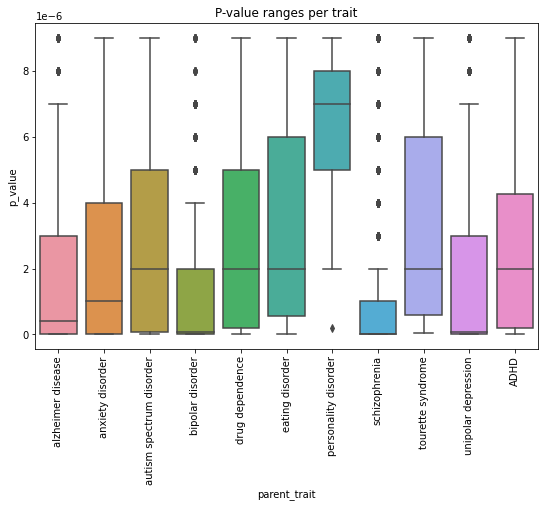

In [9]:
fig, ax = plt.subplots(figsize=(9, 6))
sns.boxplot(x='parent_trait', y='p_value', data=all_df, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(title='P-value ranges per trait')

The IQRs of all traits look roughly the same except for personality disorder (and schizophrenia has a much lower IQR and many outliers). It looks like filtering data points with p-values > 6e-6 may remove most of the outliers (and may need to exclude personality disorder; it also appears to have very little coverage based on the previous plots).

## Comparing gene & variant overlap

Do pairwise comparison to see which traits share implicated genes.

In [10]:
trait_to_genes = {}
for trait in all_traits:
  genes = set(trait_to_df[trait]['gene'])
  genes.remove(UNKNOWN_GENE)
  trait_to_genes[trait] = genes

# Stores dicts where keys are traits and values are # overlapping genes, to be
# used in creating a DF later.
overlapping_gene_count_dicts = []
for trait_a in all_traits:
  trait_a_dict = {}
  for trait_b in all_traits:
    if trait_a == trait_b:
      trait_a_dict[trait_a] = len(trait_to_genes[trait_a])
      continue
    
    overlapping_genes = trait_to_genes[trait_a].intersection(trait_to_genes[trait_b])
    trait_a_dict[trait_b] = len(overlapping_genes)
    if len(overlapping_genes) > 0:
      print(f'{trait_a} and {trait_b} have {len(overlapping_genes)} overlapping genes.')
  overlapping_gene_count_dicts.append(trait_a_dict)

overlap_df = pd.DataFrame(overlapping_gene_count_dicts, index=all_traits)

alzheimer disease and anxiety disorder have 13 overlapping genes.
alzheimer disease and autism spectrum disorder have 9 overlapping genes.
alzheimer disease and bipolar disorder have 18 overlapping genes.
alzheimer disease and drug dependence have 10 overlapping genes.
alzheimer disease and eating disorder have 4 overlapping genes.
alzheimer disease and schizophrenia have 48 overlapping genes.
alzheimer disease and tourette syndrome have 4 overlapping genes.
alzheimer disease and unipolar depression have 30 overlapping genes.
alzheimer disease and ADHD have 11 overlapping genes.
anxiety disorder and alzheimer disease have 13 overlapping genes.
anxiety disorder and autism spectrum disorder have 6 overlapping genes.
anxiety disorder and bipolar disorder have 15 overlapping genes.
anxiety disorder and drug dependence have 8 overlapping genes.
anxiety disorder and eating disorder have 7 overlapping genes.
anxiety disorder and schizophrenia have 46 overlapping genes.
anxiety disorder and to

In [11]:
overlap_df.head()

,alzheimer disease,anxiety disorder,autism spectrum disorder,bipolar disorder,drug dependence,eating disorder,personality disorder,schizophrenia,tourette syndrome,unipolar depression,ADHD
alzheimer disease,494,13,9,18,10,4,0,48,4,30,11
anxiety disorder,13,221,6,15,8,7,0,46,2,52,9
autism spectrum disorder,9,6,144,11,4,4,0,25,2,21,12
bipolar disorder,18,15,11,508,8,9,1,159,5,56,15
drug dependence,10,8,4,8,258,4,1,34,1,22,11


Text(0.5, 0.98, 'Number of Overlapping Genes between Traits')

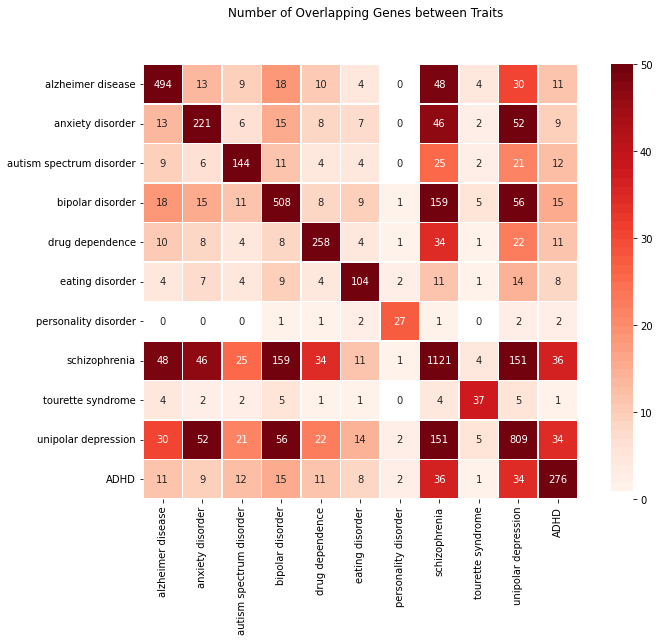

In [12]:
# Custom color map where 0 is white to emphasize no gene overlap, and 
# darkest color is at 50, so that traits with more data don't skew the chart 
# too much.
cmap_reds = plt.get_cmap('Reds')
num_colors = 50
colors = ['white'] + [cmap_reds(i / num_colors) for i in range(1, num_colors)]
cmap = LinearSegmentedColormap.from_list('', colors, num_colors)

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(overlap_df,
            cmap=cmap,
            vmin=0,
            vmax=num_colors,
            annot=True,
            fmt="d",
            linewidths=0.5,
            square=True,
            ax=ax)
fig.suptitle('Number of Overlapping Genes between Traits')

Do a similar check, except for child traits of each given parent trait

In [13]:
for parent_trait in all_traits:
  trait_row = metadata_df.loc[metadata_df['Trait'] == parent_trait]
  child_trait_entry = trait_row['Child traits'].astype(str)
  if len(child_trait_entry) == 0:
    continue

  child_traits = child_trait_entry.tolist()[0].split(CHILD_TRAIT_DELIMITER)
  child_traits = [c_trait.strip().lower() for c_trait in child_traits]
  trait_to_genes = {}
  for child_trait in child_traits:
    parent_df = trait_to_df[parent_trait]
    child_trait_df = parent_df.loc[parent_df['trait'] == child_trait]
    child_trait_genes = set(child_trait_df['gene'].unique())
    if UNKNOWN_GENE in child_trait_genes:
      child_trait_genes.remove(UNKNOWN_GENE)
    trait_to_genes[child_trait] = child_trait_genes

  for child_trait_a in child_traits:
    for child_trait_b in child_traits:
      if child_trait_a == child_trait_b:
        continue
      
      genes_a = trait_to_genes[child_trait_a]
      genes_b = trait_to_genes[child_trait_b]
      overlapping_genes = genes_a.intersection(genes_b)
      if len(overlapping_genes) > 0:
        print(f'{child_trait_a} and {child_trait_b} have {len(overlapping_genes)} overlapping genes.')  

neurotic disorder and obsessive-compulsive disorder have 1 overlapping genes.
neurotic disorder and post-traumatic stress disorder have 1 overlapping genes.
obsessive-compulsive disorder and neurotic disorder have 1 overlapping genes.
obsessive-compulsive disorder and panic disorder have 1 overlapping genes.
obsessive-compulsive disorder and post-traumatic stress disorder have 1 overlapping genes.
panic disorder and obsessive-compulsive disorder have 1 overlapping genes.
panic disorder and post-traumatic stress disorder have 1 overlapping genes.
post-traumatic stress disorder and neurotic disorder have 1 overlapping genes.
post-traumatic stress disorder and obsessive-compulsive disorder have 1 overlapping genes.
post-traumatic stress disorder and panic disorder have 1 overlapping genes.
alcohol and nicotine codependence and alcohol dependence have 1 overlapping genes.
alcohol dependence and alcohol and nicotine codependence have 1 overlapping genes.
alcohol dependence and nicotine depe

Finally check if any variants are implicated in multiple (parent) traits

In [14]:
trait_to_variants = {}
for trait in all_traits:
  variants = set(trait_to_df[trait]['variant_and_allele'].unique())
  trait_to_variants[trait] = variants

 
for trait_a in all_traits:
  for trait_b in all_traits:
    if trait_a == trait_b:
      continue
    
    overlapping_variants = trait_to_variants[trait_a].intersection(trait_to_variants[trait_b])
    if len(overlapping_variants) > 0:
      print(f'{trait_a} and {trait_b} have {len(overlapping_variants)} overlapping variants.')

anxiety disorder and unipolar depression have 5 overlapping variants.
autism spectrum disorder and bipolar disorder have 1 overlapping variants.
autism spectrum disorder and schizophrenia have 1 overlapping variants.
autism spectrum disorder and unipolar depression have 1 overlapping variants.
autism spectrum disorder and ADHD have 2 overlapping variants.
bipolar disorder and autism spectrum disorder have 1 overlapping variants.
bipolar disorder and schizophrenia have 77 overlapping variants.
bipolar disorder and unipolar depression have 1 overlapping variants.
schizophrenia and autism spectrum disorder have 1 overlapping variants.
schizophrenia and bipolar disorder have 77 overlapping variants.
schizophrenia and unipolar depression have 6 overlapping variants.
schizophrenia and ADHD have 1 overlapping variants.
unipolar depression and anxiety disorder have 5 overlapping variants.
unipolar depression and autism spectrum disorder have 1 overlapping variants.
unipolar depression and bipo

Sanity-check a few of those.

In [15]:
adhd_variants = trait_to_variants['ADHD']
autism_variants = trait_to_variants['autism spectrum disorder']
overlapping_variants = adhd_variants.intersection(autism_variants)
print(overlapping_variants)

{'rs6584649-<b>?</b>', 'rs4916723-<b>C</b>'}


In [16]:
depression_variants = trait_to_variants['unipolar depression']
anxiety_variants = trait_to_variants['anxiety disorder']
overlapping_variants = depression_variants.intersection(anxiety_variants)
print(overlapping_variants)

{'rs4543289-<b>?</b>', 'rs30266-<b>A</b>', 'rs3807866-<b>A</b>', 'rs3135296-<b>?</b>', 'rs1002656-<b>C</b>'}


## Compare allele frequencies

Text(0, 0.5, 'Trait')

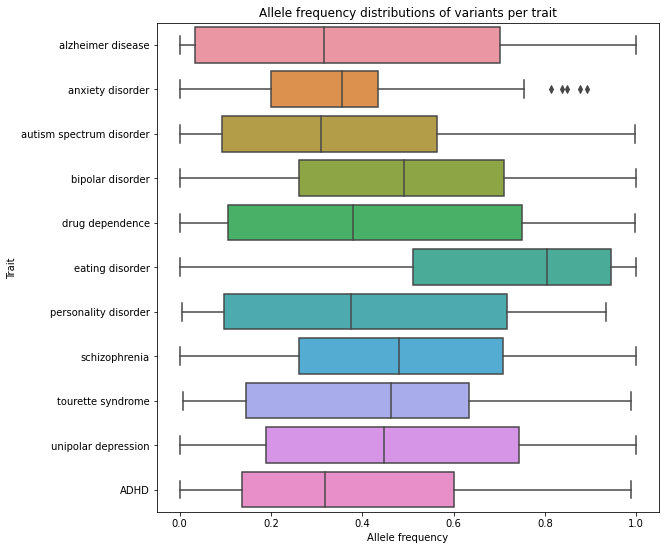

In [17]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.boxplot(x='af', y='parent_trait', data=all_df[all_df['af'] >= 0.0], ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(title='Allele frequency distributions of variants per trait')
plt.xlabel('Allele frequency')
plt.ylabel('Trait')

Observations:
*    Eating disorder has a suspiciously high average AF.
*    All traits seems to be bounded by [0, 1]
*    With the exception of anxiety disorder, which appears to have the tightest IQR.

In [18]:
missing_af_data_per_trait = all_df[all_df['af'] < 0.0].groupby('parent_trait').size()
missing_af_data_per_trait

parent_trait
ADHD                        175
alzheimer disease           313
anxiety disorder            131
autism spectrum disorder     54
bipolar disorder            279
drug dependence             112
eating disorder              14
personality disorder          8
schizophrenia               833
unipolar depression         213
dtype: int64

## Tissue associations

A variant has entries in the 'tissues' column if the variant was found to be significantly associated with gene expression in that tissue via cis-QTL analysis (+/- 1Mb windows around transcription start site, according to [GTEx portal](https://www.gtexportal.org/home/faq).

In [19]:
all_df['tissues'] = all_df['tissues'].fillna('')

In [20]:
# In previous cleaning, if a variant mapped to multiple genes, I created 
# separate rows for it. For tissue association I just blindly match the variant
# location and don't care about the gene though... so drop duplicate locations
# as they may misrepresent total counts in subsequent tissue analysis here.
tissues_df = all_df.copy()
tissues_df.drop_duplicates(subset=['location', 'parent_trait'], inplace=True)
total_variants = len(tissues_df)
tissues_df['has_tissues'] = tissues_df['tissues'].map(lambda tissues: len(tissues) > 0)
tissues_df = tissues_df[tissues_df['has_tissues'] == True]
num_variants_with_tissues = len(tissues_df)
print(f'{num_variants_with_tissues} variants significantly associated with tissues of {total_variants} total.')

1480 variants significantly associated with tissues of 4615 total.


In [21]:
tissue_metadata_file = 'tissue_metadata.txt'
all_tissues = []
with open(tissue_metadata_file) as tissue_file:
  for tissue in tissue_file.readlines():
    all_tissues.append(tissue.replace("\n", ""))

print(all_tissues)

['Adipose_Subcutaneous', 'Adipose_Visceral_Omentum', 'Adrenal_Gland', 'Artery_Aorta', 'Artery_Coronary', 'Artery_Tibial', 'Brain_Amygdala', 'Brain_Anterior_cingulate_cortex_BA24', 'Brain_Caudate_basal_ganglia', 'Brain_Cerebellar_Hemisphere', 'Brain_Cerebellum', 'Brain_Cortex', 'Brain_Frontal_Cortex_BA9', 'Brain_Hippocampus', 'Brain_Hypothalamus', 'Brain_Nucleus_accumbens_basal_ganglia', 'Brain_Putamen_basal_ganglia', 'Brain_Spinal_cord_cervical_c-1', 'Brain_Substantia_nigra', 'Breast_Mammary_Tissue', 'Cells_Cultured_fibroblasts', 'Cells_EBV-transformed_lymphocytes', 'Colon_Sigmoid', 'Colon_Transverse', 'Esophagus_Gastroesophageal_Junction', 'Esophagus_Mucosa', 'Esophagus_Muscularis', 'Heart_Atrial_Appendage', 'Heart_Left_Ventricle', 'Kidney_Cortex', 'Liver', 'Lung', 'Minor_Salivary_Gland', 'Muscle_Skeletal', 'Nerve_Tibial', 'Ovary', 'Pancreas', 'Pituitary', 'Prostate', 'Skin_Not_Sun_Exposed_Suprapubic', 'Skin_Sun_Exposed_Lower_leg', 'Small_Intestine_Terminal_Ileum', 'Spleen', 'Stomach'

### Some unsuccessful attempts to visualize tissue association per-trait...

In [22]:
# Aggregate number of per-tissue associations per trait.
# This is a dict from trait to Dict[tissue, tissue association count]
trait_to_tissue_to_count = {}
for trait in all_traits:
  trait_to_tissue_to_count[trait] = {tissue: 0 for tissue in all_tissues}

for _, row in tissues_df.iterrows():
  trait = row['parent_trait']
  variant_tissues = row['tissues'].split(TISSUE_DELIM)
  for tissue in variant_tissues:
    trait_to_tissue_to_count[trait][tissue] += 1

rows = []
index = []
for trait, tissue_dict in trait_to_tissue_to_count.items():
  index.append(trait)
  rows.append(tissue_dict)

trait_to_tissue_count_df = pd.DataFrame(rows, index=index)
trait_to_tissue_count_df.head()

,Adipose_Subcutaneous,Adipose_Visceral_Omentum,Adrenal_Gland,Artery_Aorta,Artery_Coronary,Artery_Tibial,Brain_Amygdala,Brain_Anterior_cingulate_cortex_BA24,Brain_Caudate_basal_ganglia,Brain_Cerebellar_Hemisphere,...,Skin_Not_Sun_Exposed_Suprapubic,Skin_Sun_Exposed_Lower_leg,Small_Intestine_Terminal_Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole_Blood
alzheimer disease,44,31,23,30,8,41,7,4,20,27,...,36,41,14,31,24,33,50,4,3,44
anxiety disorder,12,13,8,14,7,22,3,7,10,14,...,17,19,6,10,10,20,22,2,3,21
autism spectrum disorder,11,10,5,10,3,11,3,6,6,10,...,11,12,4,7,5,11,12,1,3,14
bipolar disorder,80,70,51,78,33,91,10,33,50,47,...,79,97,38,59,53,87,106,9,14,80
drug dependence,35,20,12,27,15,43,4,6,17,21,...,37,37,14,21,23,35,55,4,4,23


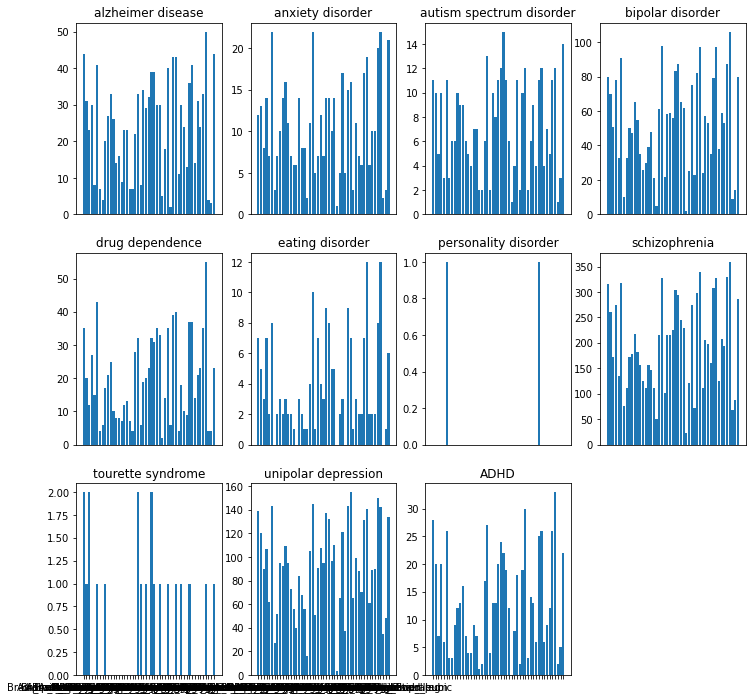

In [23]:
fig_width = 12
fig_height = 12
rows = 3
cols = 4
fig, axs = plt.subplots(figsize=(fig_width, fig_height),
                        nrows=rows,
                        ncols=cols)
subplot_height = fig_height / rows
subplot_width = fig_width / cols
axs_flat = axs.flatten()
for idx, trait in enumerate(all_traits):
  trait_data = trait_to_tissue_count_df.loc[trait]
  ax = axs_flat[idx]
  barplot = ax.bar(trait_to_tissue_count_df.columns, trait_data.values)
  if math.floor(idx / cols) < rows - 1:
    ax.axes.xaxis.set_visible(False)
  ax.set(title=trait)

fig.delaxes(axs_flat[-1])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()

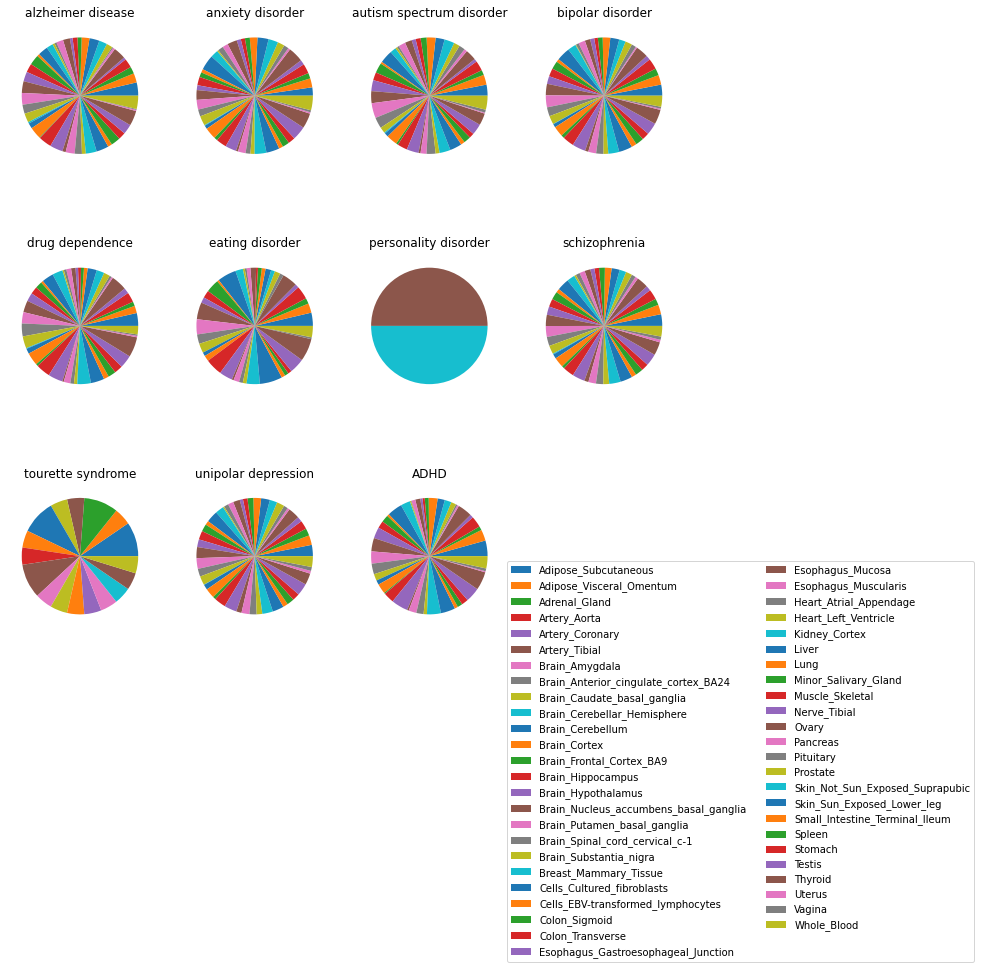

In [24]:
fig_width = 12
fig_height = 12
rows = 3
cols = 4
fig, axs = plt.subplots(figsize=(fig_width, fig_height),
                        nrows=rows,
                        ncols=cols)

axs_flat = axs.flatten()
for idx, trait in enumerate(all_traits):
  trait_data = trait_to_tissue_count_df.loc[trait]
  ax = axs_flat[idx]
  if math.floor(idx / cols) < rows - 1:
    ax.axes.xaxis.set_visible(False)
  ax.pie(trait_data)
  ax.set(title=trait)

fig.delaxes(axs_flat[-1])
plt.xticks(rotation = 90)
plt.legend(trait_to_tissue_count_df.columns, loc='best', ncol=2, bbox_to_anchor=(1, 0., 0.5, 0.5))
plt.show()

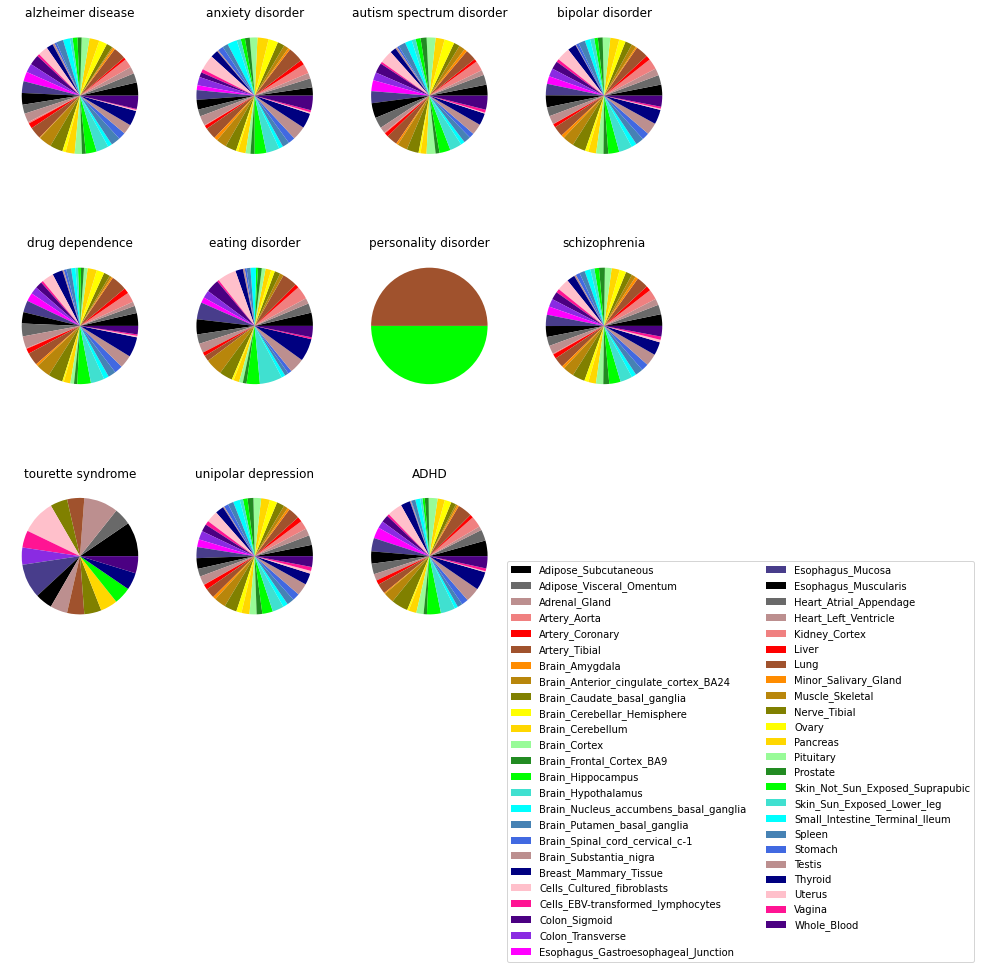

In [25]:
fig_width = 12
fig_height = 12
rows = 3
cols = 4
fig, axs = plt.subplots(figsize=(fig_width, fig_height),
                        nrows=rows,
                        ncols=cols)
colors = ['black', 'dimgray', 'rosybrown', 'lightcoral', 'red', 
            'sienna', 'darkorange', 'darkgoldenrod', 'olive', 'yellow', 
            'gold', 'palegreen', 'forestgreen', 'lime', 'turquoise',
            'aqua', 'steelblue', 'royalblue', 'rosybrown', 'navy',
            'pink', 'deeppink', 'indigo', 'blueviolet', 'magenta', 
            'darkslateblue']

axs_flat = axs.flatten()
for idx, trait in enumerate(all_traits):
  trait_data = trait_to_tissue_count_df.loc[trait]
  ax = axs_flat[idx]
  if math.floor(idx / cols) < rows - 1:
    ax.axes.xaxis.set_visible(False)
  ax.pie(trait_data, colors=colors)
  ax.set(title=trait)

fig.delaxes(axs_flat[-1])
plt.xticks(rotation = 90)
plt.legend(trait_to_tissue_count_df.columns, loc='best', ncol=2, bbox_to_anchor=(1, 0., 0.5, 0.5))
plt.show()

In [26]:
len(all_tissues)

49

Too many values for unique colors...

In [27]:
sums = trait_to_tissue_count_df.sum(axis=0)
sums.sort_values(inplace=True)
sums[0:25].index.tolist()

['Kidney_Cortex',
 'Brain_Substantia_nigra',
 'Uterus',
 'Brain_Amygdala',
 'Minor_Salivary_Gland',
 'Vagina',
 'Cells_EBV-transformed_lymphocytes',
 'Brain_Hypothalamus',
 'Brain_Spinal_cord_cervical_c-1',
 'Brain_Anterior_cingulate_cortex_BA24',
 'Ovary',
 'Brain_Hippocampus',
 'Liver',
 'Artery_Coronary',
 'Small_Intestine_Terminal_Ileum',
 'Prostate',
 'Brain_Frontal_Cortex_BA9',
 'Brain_Putamen_basal_ganglia',
 'Brain_Nucleus_accumbens_basal_ganglia',
 'Adrenal_Gland',
 'Brain_Caudate_basal_ganglia',
 'Pituitary',
 'Brain_Cerebellar_Hemisphere',
 'Brain_Cortex',
 'Stomach']

In [28]:
tissue_plotting_df = trait_to_tissue_count_df.copy()
columns_to_retain = set(tissue_plotting_df.columns.tolist()).difference(set(sums[0:25].index.tolist()))
columns_to_retain_list = [col for col in columns_to_retain]
tissue_plotting_df = tissue_plotting_df[columns_to_retain_list]

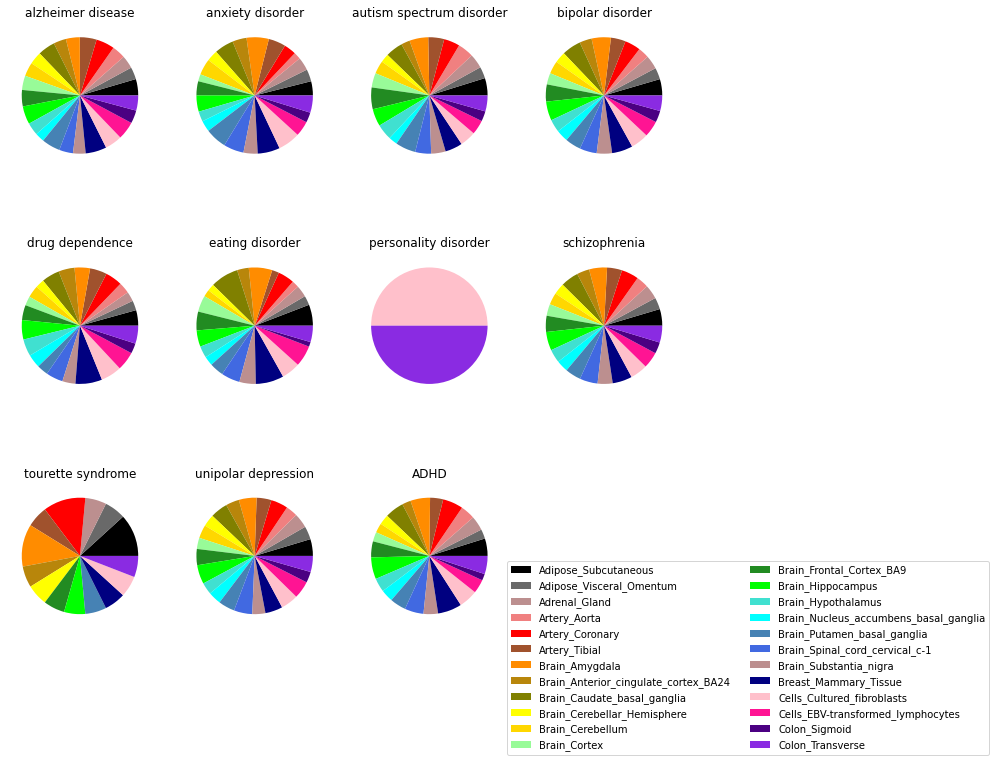

In [29]:
fig_width = 12
fig_height = 12
rows = 3
cols = 4
fig, axs = plt.subplots(figsize=(fig_width, fig_height),
                        nrows=rows,
                        ncols=cols)
colors = ['black', 'dimgray', 'rosybrown', 'lightcoral', 'red', 
            'sienna', 'darkorange', 'darkgoldenrod', 'olive', 'yellow', 
            'gold', 'palegreen', 'forestgreen', 'lime', 'turquoise',
            'aqua', 'steelblue', 'royalblue', 'rosybrown', 'navy',
            'pink', 'deeppink', 'indigo', 'blueviolet', 'magenta', 
            'darkslateblue']

axs_flat = axs.flatten()
for idx, trait in enumerate(all_traits):
  trait_data = tissue_plotting_df.loc[trait]
  ax = axs_flat[idx]
  if math.floor(idx / cols) < rows - 1:
    ax.axes.xaxis.set_visible(False)
  ax.pie(trait_data, colors=colors)
  ax.set(title=trait)

fig.delaxes(axs_flat[-1])
plt.xticks(rotation = 90)
plt.legend(trait_to_tissue_count_df.columns, loc='best', ncol=2, bbox_to_anchor=(1, 0., 0.5, 0.5))
plt.show()

### Re-analyzing other variables with only the tissue-associated variants

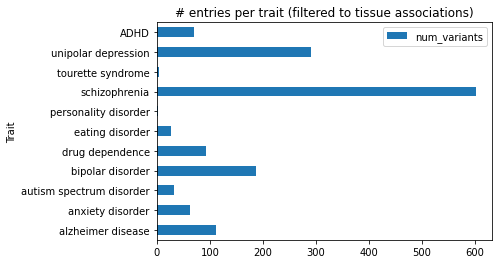

In [30]:
trait_summaries = []
for trait in all_traits:
  trait_df = tissues_df[tissues_df['parent_trait'] == trait]
  trait_summary = {
      'parent_trait': trait,
      'num_variants': len(trait_df),
  }
  trait_summaries.append(trait_summary)

summary_df = pd.DataFrame(trait_summaries)
summary_df.plot(kind='barh', title='# entries per trait (filtered to tissue associations)',
                x='parent_trait', y='num_variants',
                xlabel='Trait')

[Text(0, 0, 'alzheimer disease'),
 Text(0, 0, 'anxiety disorder'),
 Text(0, 0, 'autism spectrum disorder'),
 Text(0, 0, 'bipolar disorder'),
 Text(0, 0, 'drug dependence'),
 Text(0, 0, 'eating disorder'),
 Text(0, 0, 'personality disorder'),
 Text(0, 0, 'schizophrenia'),
 Text(0, 0, 'tourette syndrome'),
 Text(0, 0, 'unipolar depression'),
 Text(0, 0, 'ADHD')]

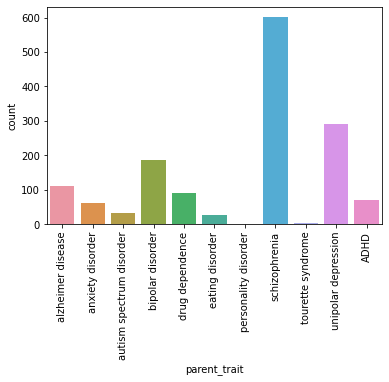

In [31]:
ax = sns.countplot(x='parent_trait', data=tissues_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

Text(0, 0.5, 'Trait')

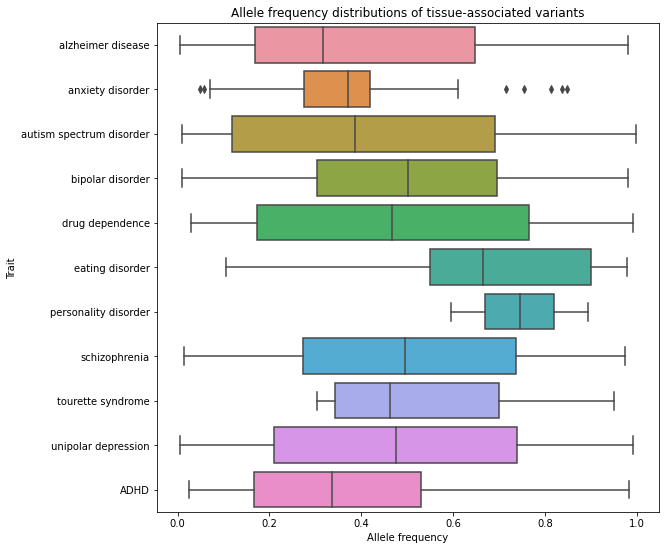

In [32]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.boxplot(x='af', y='parent_trait', data=tissues_df[tissues_df['af'] >= 0.0], ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(title='Allele frequency distributions of tissue-associated variants')
plt.xlabel('Allele frequency')
plt.ylabel('Trait')

### Focusing on tissue associations of one trait

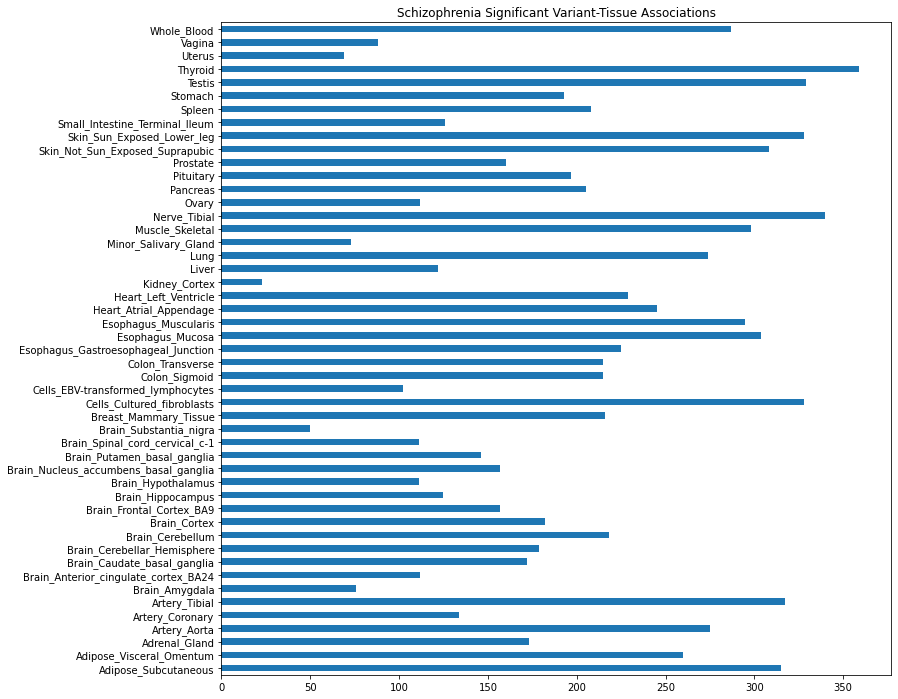

In [33]:
fig, ax = plt.subplots(figsize=(12,12))
trait_to_tissue_count_df.loc['schizophrenia'].plot(
    kind='barh', 
    ax=ax, 
    title='Schizophrenia Significant Variant-Tissue Associations')

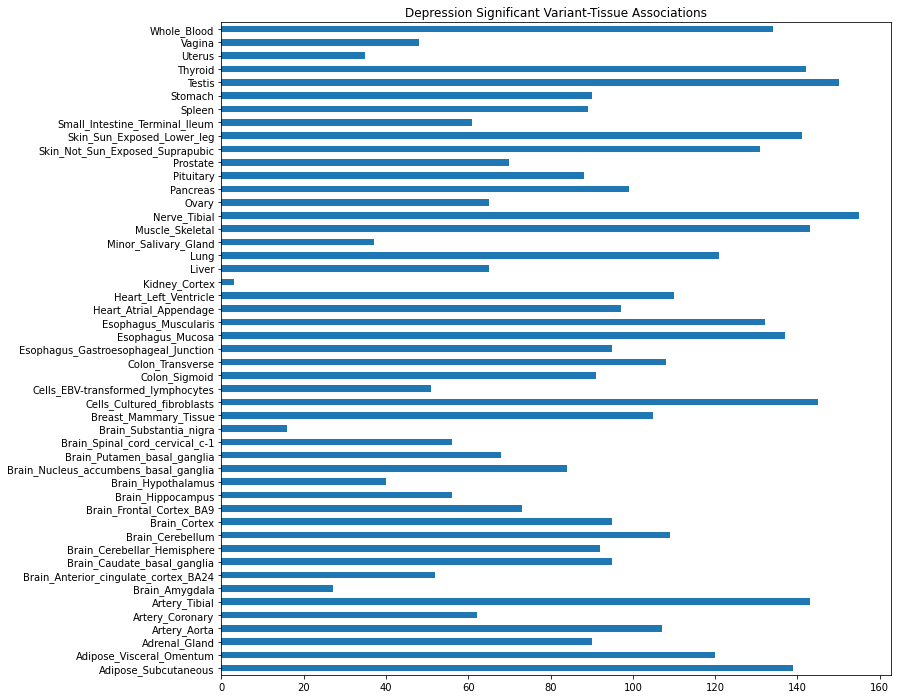

In [34]:
fig, ax = plt.subplots(figsize=(12,12))
trait_to_tissue_count_df.loc['unipolar depression'].plot(
    kind='barh', 
    ax=ax, 
    title='Depression Significant Variant-Tissue Associations')